In [2]:
import librosa
import librosa.display
import sounddevice as sd
# import soundfile as sf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary
from model import InstrumentDataset, InstrumentClassifier_CBAM

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
def play_wav(filename, device_id=None, volume=1.0, duration=3):
    """
    Play a WAV file for a specific duration on a specific device with adjustable volume.

    Parameters:
    - filename: Path to the WAV file
    - device_id: Index of the audio output device (None = default)
    - volume: Volume multiplier (1.0 = normal, 0.5 = half, 2.0 = double)
    - duration: Duration to play in seconds (default is 3 seconds)
    """
    # Read the audio file
    data, samplerate = sf.read(filename)

    # Adjust the volume (Ensure values stay in range [-1, 1])
    data = np.clip(data * volume, -1.0, 1.0)

    # Calculate the number of samples to play based on the desired duration
    num_samples = int(samplerate * duration)

    # Slice the data to only include the first `duration` seconds
    data = data[:num_samples]

    # Play the modified audio
    sd.play(data, samplerate, device=device_id)
    sd.wait()  # Wait until playback is done

In [4]:
def audio_to_spectrogram(audio, sr=22050, n_fft=2048, hop_length=512):
    if isinstance(audio, str):  # If input is a file path
        y, sr = librosa.load(audio, sr=sr)
    else:  # If input is a NumPy array (live audio)
        y = audio
    
    print(y.shape[0] / sr)  # Print duration in seconds

    # Compute spectrogram (STFT)
    spectrogram = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    
    # Convert to dB scale
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    times = librosa.frames_to_time(np.arange(spectrogram_db.shape[1]), sr=sr, hop_length=hop_length)
    

    return spectrogram_db, freqs, times


def audio_to_melspectrogram(audio, sr=22050, n_mel=256):
    if isinstance(audio, str):  # If input is a file path
        y, sr = librosa.load(audio, sr=sr)
    else:  # If input is a NumPy array (live audio)
        y = audio
    
    print(y.shape[0]/sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mel, n_fft=1024, hop_length=512)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB
    return mel_spec_db



3.9100226757369616


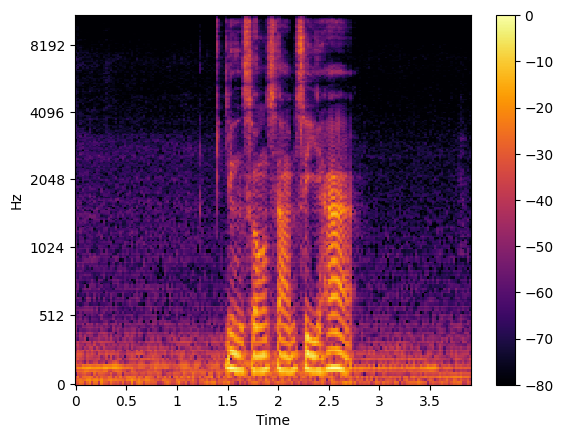

In [5]:
mel_spectrogram = audio_to_melspectrogram(r"H:\DSP_project\ignoredir\data_test\Recording2.wav")

librosa.display.specshow(mel_spectrogram, sr=22050, hop_length=512, x_axis="time", y_axis="mel", cmap="inferno")
plt.colorbar()
# plt.gca().set_aspect("equal")
plt.show()

In [6]:
volumn = 0.5
duration = 99
sr = 22050
device = 15
noise = True
noise_level=0.005
normalize = False
trim = False
trim_db = 10

y, sr = librosa.load(r"H:\DSP_project\ignoredir\data_test\Recording2.wav", sr=sr)

# if trim:
#     y, _ = librosa.effects.trim(y, top_db=trim_db)

# if noise:
#     y_noise = np.random.normal(0, 0.005 * np.max(np.abs(y)), y.shape)
#     y += y_noise

# if normalize:
#     y = librosa.util.normalize(y)

# y = np.clip(y * 0.5, -1.0, 1.0)
# num_samples = int(22050 * duration)
# y = y[:num_samples]

# # Play the modified audio
# sd.play(y, sr, device=device)
# sd.wait()  # Wait until playback is done

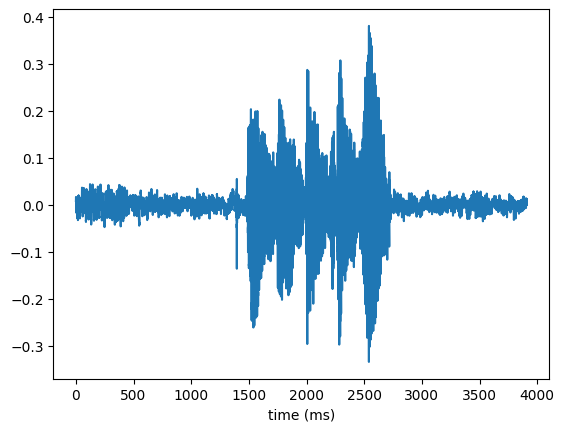

In [7]:
x = np.linspace(0 , np.round((y.shape[0]/sr)*1000).astype(np.int16), y.shape[0])
plt.plot(x,y)
plt.xlabel("time (ms)")
plt.show()

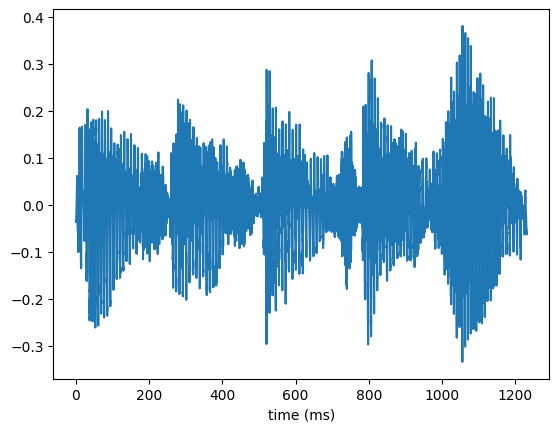

In [8]:
y, _ = librosa.effects.trim(y, top_db=10)
x = np.linspace(0 , np.round((y.shape[0]/sr)*1000).astype(np.int16), y.shape[0])
plt.plot(x,y)
plt.xlabel("time (ms)")
plt.show()

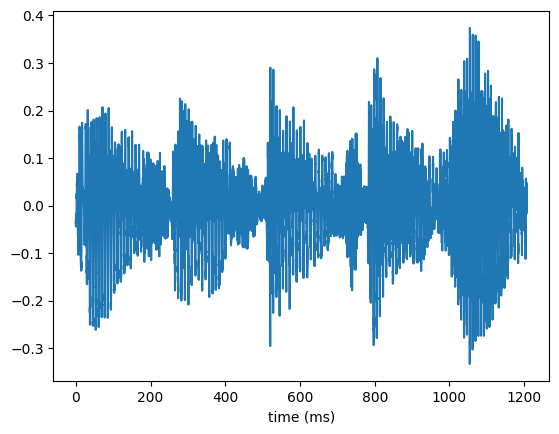

In [9]:
y, _ = librosa.effects.trim(y, top_db=10)
noise_level=0.005
noise = np.random.normal(0, noise_level, y.shape)
y += noise
x = np.linspace(0 , np.round((y.shape[0]/sr)*1000).astype(np.int16), y.shape[0])
plt.plot(x,y)
plt.xlabel("time (ms)")
plt.show()

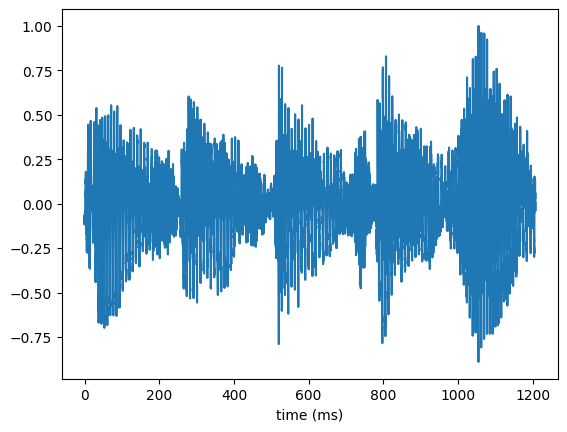

In [10]:
y = librosa.util.normalize(y)
y.shape[0]/sr
plt.plot(x,y)
plt.xlabel("time (ms)")
plt.show()

In [11]:
# y = y[:int(sr*1)]
# x = x[:int(sr*1)]
# plt.plot(x,y)
# plt.xlabel("time (ms)")
# plt.show()

1.0


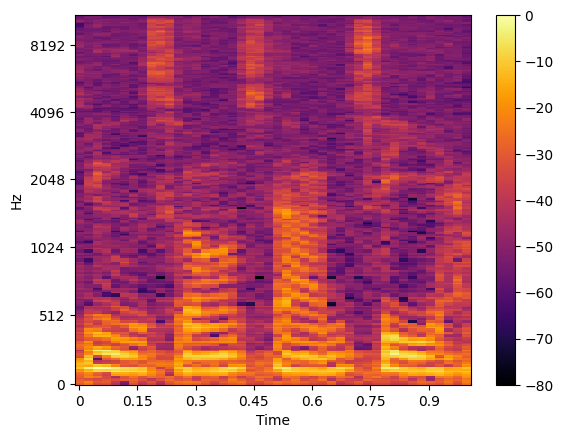

In [12]:
duration = 1
mel_spectrogram = audio_to_melspectrogram(y[:22050*duration], sr=22050, n_mel=256)

librosa.display.specshow(mel_spectrogram, sr=22050, hop_length=512, x_axis="time", y_axis="mel", cmap="inferno")
plt.colorbar()
# plt.gca().set_aspect("equal")
plt.show()

In [13]:
data_df = pd.read_csv(r"H:\DSP_project\model\train_model\God_data.csv", index_col=0)
data_df = data_df.groupby('Class').apply(lambda x: x.sample(n=min(len(x), 250))).reset_index(drop=True)
data_df = data_df.drop_duplicates()

C:\Users\gotxz\AppData\Local\Temp\ipykernel_22432\1805993838.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_df = data_df.groupby('Class').apply(lambda x: x.sample(n=min(len(x), 250))).reset_index(drop=True)


In [14]:
# onehot = OneHotEncoder(sparse_output=False)
# onehot.fit(data_df["Class"].unique().reshape(-1,1))

# map_index_class = {}
# for i in range(len(onehot.categories_[0])):
#     onehot_vec = [0]*28
#     onehot_vec[i] = 1
#     onehot_vec = [onehot_vec]
#     true_class = onehot.inverse_transform(onehot_vec)
#     map_index_class[i] = true_class[0][0]
#     print(i, true_class[0][0])
    

# with open("encoder.pkl", "wb") as f:
#     encoder = {"encoder" : onehot,
#                "map_index_class" : map_index_class}
#     pickle.dump(encoder, f)

In [15]:
with open(r"H:\DSP_project\model\train_model\encoder.pkl", "rb") as f:
        encoder = pickle.load(f)
onehot = encoder["encoder"]
map_index_class = encoder["map_index_class"]

In [16]:
map_index_class

{0: 'Accordion',
 1: 'Acoustic_Guitar',
 2: 'Banjo',
 3: 'Bass_Guitar',
 4: 'Clarinet',
 5: 'Cymbals',
 6: 'Dobro',
 7: 'Drum_set',
 8: 'Electro_Guitar',
 9: 'Floor_Tom',
 10: 'Harmonica',
 11: 'Harmonium',
 12: 'Hi_Hats',
 13: 'Horn',
 14: 'Keyboard',
 15: 'Mandolin',
 16: 'Organ',
 17: 'Piano',
 18: 'Saxophone',
 19: 'Shakers',
 20: 'Tambourine',
 21: 'Trombone',
 22: 'Trumpet',
 23: 'Ukulele',
 24: 'Violin',
 25: 'cowbell',
 26: 'flute',
 27: 'vibraphone'}

In [17]:
dull_df, test_df = train_test_split(data_df, test_size=0.1, random_state=42, shuffle=True)
train_df, val_df = train_test_split(dull_df, test_size=0.2, random_state=42, shuffle=True)

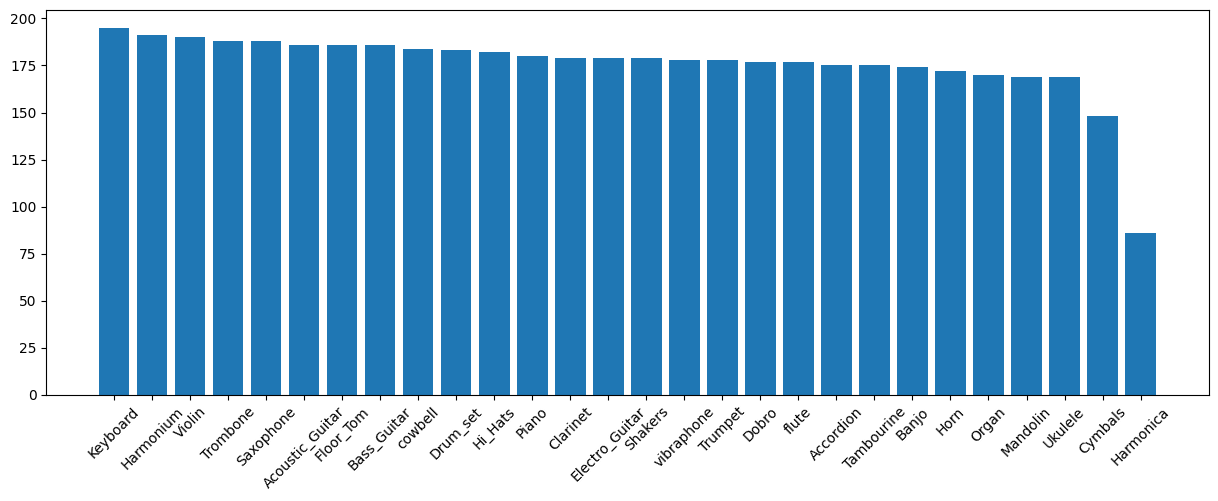

In [18]:
test = train_df.value_counts("Class")
plt.figure(figsize=(15,5))
plt.bar(test.index, test)
plt.xticks(rotation=45)
plt.show()

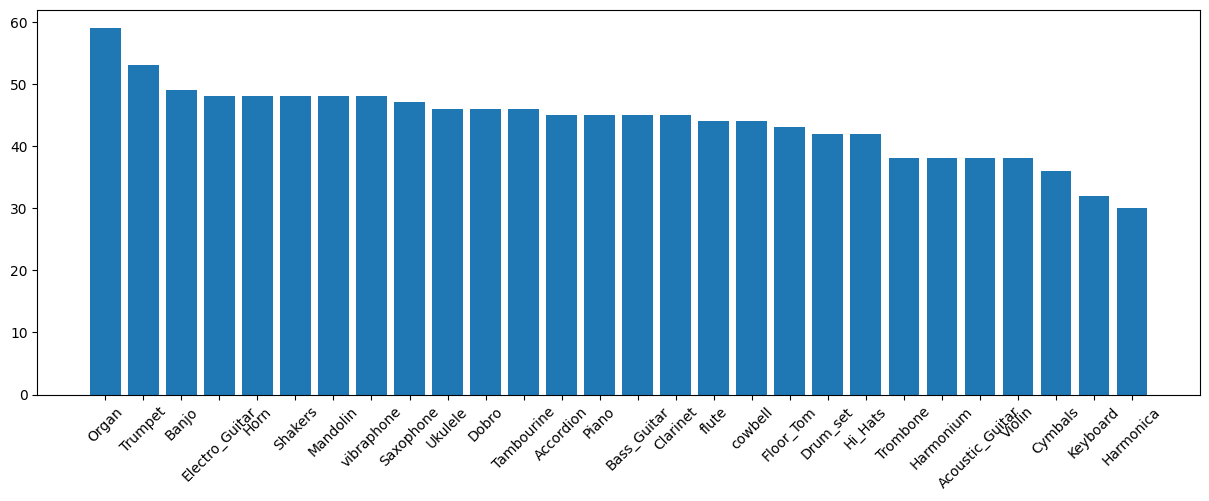

In [19]:
test = val_df.value_counts("Class")
plt.figure(figsize=(15,5))
plt.bar(test.index, test)
plt.xticks(rotation=45)
plt.show()

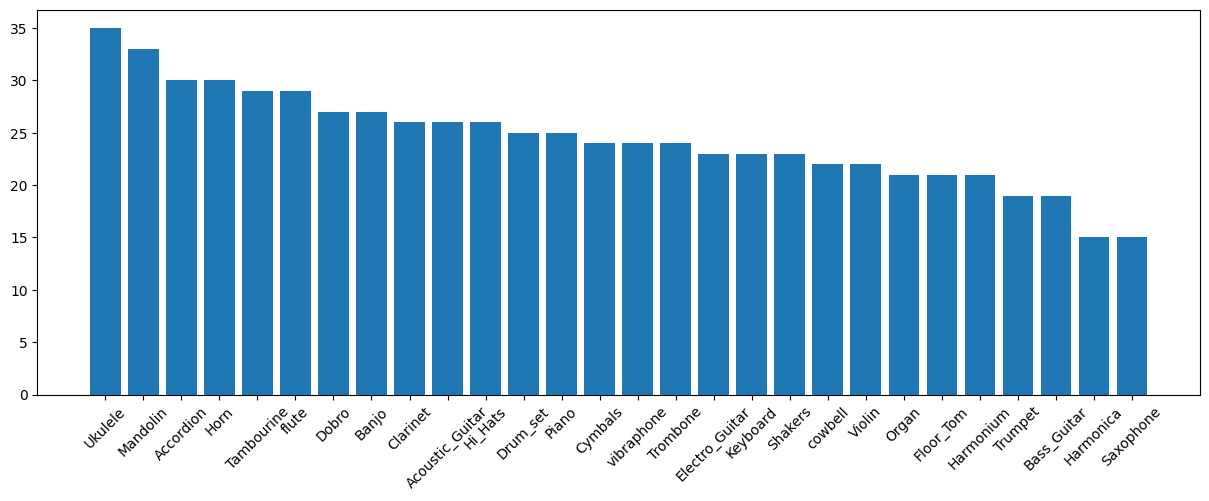

In [20]:
test = test_df.value_counts("Class")
plt.figure(figsize=(15,5))
plt.bar(test.index, test)
plt.xticks(rotation=45)
plt.show()

In [21]:
train_dataset = InstrumentDataset(train_df, onehot, n_mels=256)
train_dataloader = DataLoader(train_dataset, batch_size=3200, shuffle=True)

val_dataset = InstrumentDataset(val_df, onehot)
val_dataloader = DataLoader(val_dataset, batch_size=3200, shuffle=True)

test_dataset = InstrumentDataset(test_df, onehot)
test_dataloader = DataLoader(test_dataset, batch_size=3200, shuffle=True)

data = {
    "train_dataset" : train_dataset,
    "train_dataloader" : train_dataloader,
    "val_dataset" : val_dataset,
    "val_dataloader" : val_dataloader,
    "test_dataset" : test_dataset,
    "test_dataloader" : test_dataloader
    }

with open("data_model_noise2.pkl", "wb") as f:
    pickle.dump(data, f)

In [39]:
test_dataset[0][0].shape

torch.Size([1, 256, 44])

In [22]:
# with open(r"H:\DSP_project\ignoredir\dataset\data_model.pkl", "rb") as f:
#     data_mode = pickle.load(f)
#     train_dataset = data_mode["train_dataset"]
#     train_dataloader = data_mode["train_dataloader"]
#     val_dataset = data_mode["val_dataset"],
#     val_dataloader = data_mode["val_dataloader"],
#     test_dataset = data_mode["test_dataset"]
#     test_dataloader = data_mode["test_dataloader"]
    

In [23]:
def conv_output_size(input_width, input_height, kernel_size, stride, padding):
    """
    Calculate the output width and height of a convolutional layer.
    
    Parameters:
    - input_width: Width of the input (W_in)
    - input_height: Height of the input (H_in)
    - kernel_size: Size of the convolutional kernel (K_h, K_w)
    - stride: Stride of the convolution (S)
    - padding: Padding applied (P)
    
    Returns:
    - output_width: Width of the output (W_out)
    - output_height: Height of the output (H_out)
    """
    # Calculate output height and width using the formula
    output_height = (input_height - kernel_size + 2 * padding) // stride + 1
    output_width = (input_width - kernel_size + 2 * padding) // stride + 1
    
    return output_width, output_height

# Example usage:
input_width = 11
input_height = 64
kernel_size = 2
stride = 2
padding = 0

output_width, output_height = conv_output_size(input_width, input_height, kernel_size, stride, padding)

print(f"Output size: {output_width} x {output_height}")


Output size: 5 x 32


In [24]:
# Initialize model
model = InstrumentClassifier_CBAM(28)

# Check if GPU is available, if so move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print model summary
summary(model, input_size=(1, 256, 44))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 256, 44]              80
         MaxPool2d-2           [-1, 8, 128, 22]               0
 AdaptiveAvgPool2d-3              [-1, 8, 1, 1]               0
            Conv2d-4              [-1, 1, 1, 1]               8
              ReLU-5              [-1, 1, 1, 1]               0
            Conv2d-6              [-1, 8, 1, 1]               8
           Sigmoid-7              [-1, 8, 1, 1]               0
            Conv2d-8           [-1, 1, 128, 22]              98
           Sigmoid-9           [-1, 1, 128, 22]               0
             CBAM-10           [-1, 8, 128, 22]               0
      BatchNorm2d-11           [-1, 8, 128, 22]              16
           Conv2d-12          [-1, 16, 128, 22]           1,168
        MaxPool2d-13           [-1, 16, 64, 11]               0
AdaptiveAvgPool2d-14             [-1, 1

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(onehot.get_feature_names_out())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InstrumentClassifier_CBAM(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
epoches = 300

train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_wts = None
last_mode_wts = None

for epoch in range(epoches):  # Train for 50 epochs
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    
    # Training phase
    batch = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        # print(f"epoch: {epoch}, batch: {batch}, loss: {loss:.2f}" )
        batch+=1
    
    # Average training loss for the epoch
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
    
    # Average validation loss for the epoch
    avg_val_loss = running_val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)
    
    # Save the best model weights based on validation loss
    last_mode_wts = model.state_dict()
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = model.state_dict()
    
    # Print loss statistics for this epoch
    print(f"Epoch {epoch+1}/{epoches}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Load best model weights (if training is stopped)
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "instrument_classifier_cbam_300_0.00001_best_2.pt")

model.load_state_dict(last_mode_wts)
torch.save(model.state_dict(), "instrument_classifier_cbam_300_0.00001_last_2.pt")

Epoch 1/300, Training Loss: 3.3219, Validation Loss: 3.3222
Epoch 2/300, Training Loss: 3.3047, Validation Loss: 3.3054
Epoch 3/300, Training Loss: 3.2807, Validation Loss: 3.2675
Epoch 4/300, Training Loss: 3.2430, Validation Loss: 3.2101
Epoch 5/300, Training Loss: 3.1883, Validation Loss: 3.1257
Epoch 6/300, Training Loss: 3.1167, Validation Loss: 3.0397
Epoch 7/300, Training Loss: 3.0341, Validation Loss: 2.9276
Epoch 8/300, Training Loss: 2.9525, Validation Loss: 2.8203
Epoch 9/300, Training Loss: 2.8734, Validation Loss: 2.7322
Epoch 10/300, Training Loss: 2.7937, Validation Loss: 2.6559
Epoch 11/300, Training Loss: 2.7105, Validation Loss: 2.5584
Epoch 12/300, Training Loss: 2.6234, Validation Loss: 2.4748
Epoch 13/300, Training Loss: 2.5315, Validation Loss: 2.3767
Epoch 14/300, Training Loss: 2.4386, Validation Loss: 2.2905
Epoch 15/300, Training Loss: 2.3444, Validation Loss: 2.1866
Epoch 16/300, Training Loss: 2.2513, Validation Loss: 2.1056
Epoch 17/300, Training Loss: 2.15

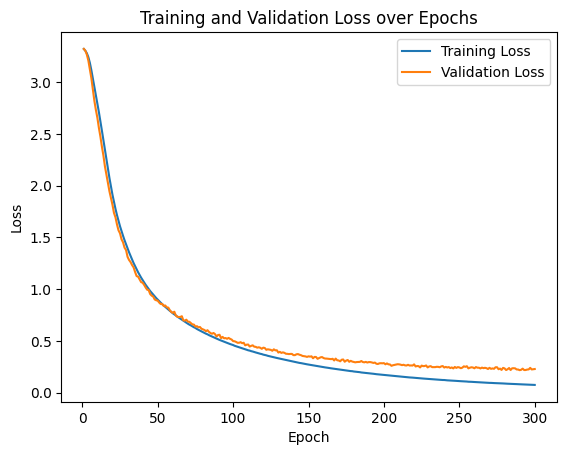

In [38]:
plt.plot(range(1, epoches+1), train_losses, label='Training Loss')
plt.plot(range(1, epoches+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

Classification Report:
                  precision    recall  f1-score   support

      Accordion       0.87      0.83      0.85       249
Acoustic_Guitar       0.92      0.88      0.90       373
          Banjo       0.96      0.81      0.88       200
    Bass_Guitar       0.99      0.98      0.99       148
       Clarinet       0.95      0.91      0.93       201
        Cymbals       0.95      0.92      0.93       140
          Dobro       0.93      0.91      0.92       217
       Drum_set       0.94      0.89      0.91       245
 Electro_Guitar       0.85      0.88      0.87       189
      Floor_Tom       0.69      0.84      0.76        69
      Harmonica       0.99      1.00      1.00       103
      Harmonium       0.99      1.00      1.00       177
        Hi_Hats       0.84      0.85      0.85       151
           Horn       1.00      1.00      1.00       223
       Keyboard       0.99      1.00      0.99       199
       Mandolin       0.97      0.85      0.90       270
      

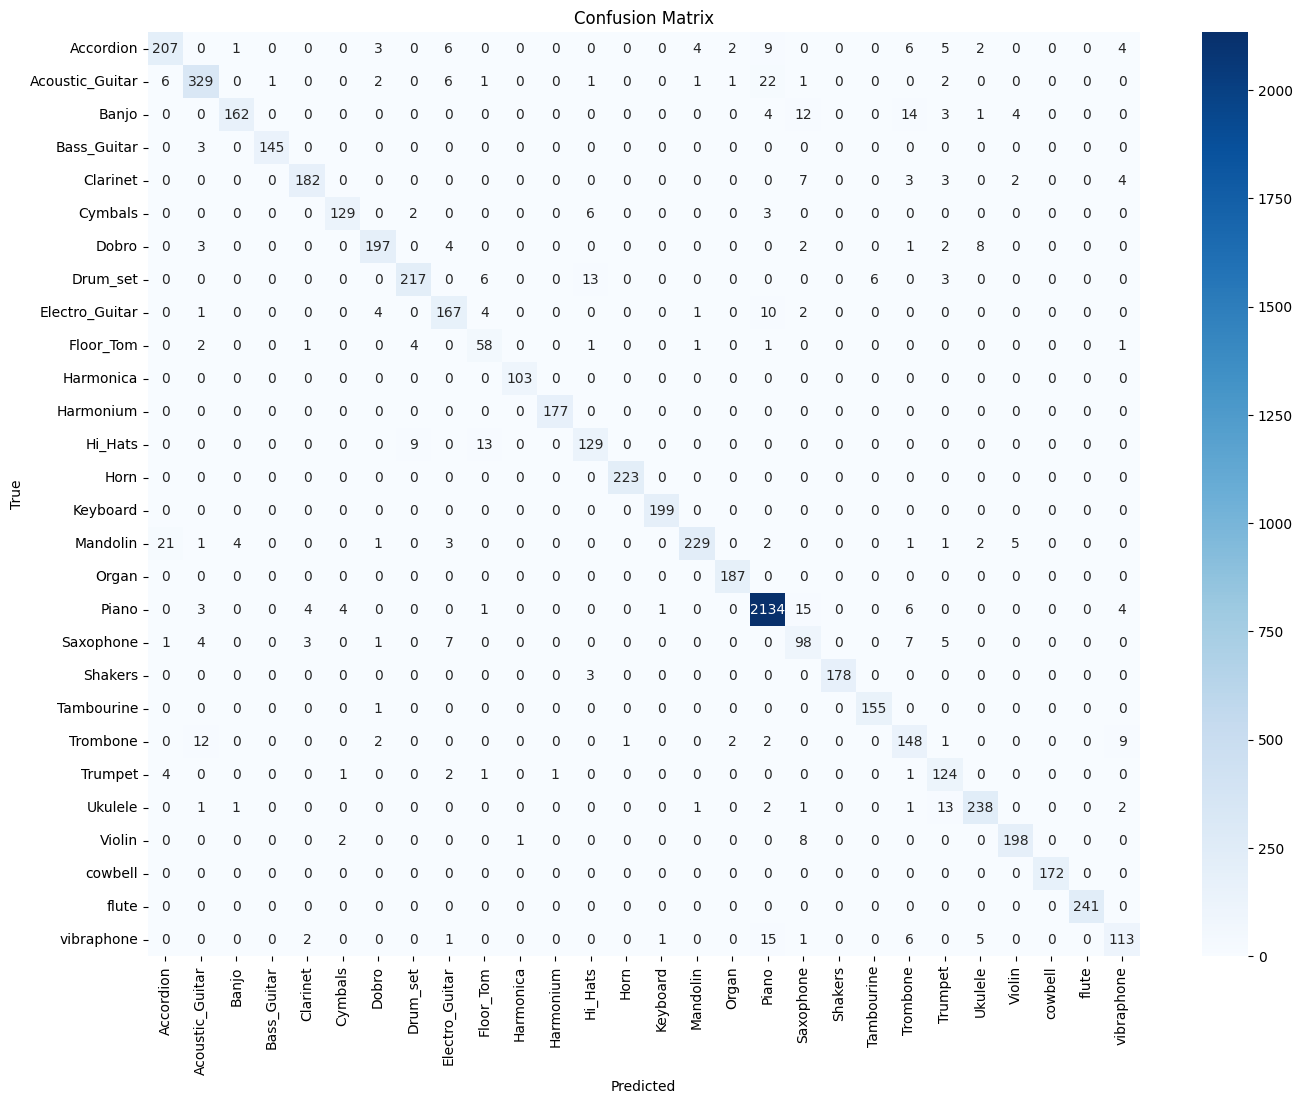

In [35]:

# Evaluate function with One-Hot Encoding and softmax
def evaluate_model(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to track gradients
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Get raw logits from the model
            outputs = model(inputs)  # Raw logits
            
            # Apply softmax to the logits to get probabilities
            probabilities = F.softmax(outputs, dim=1)
            
            # Convert probabilities to one-hot format
            preds = torch.argmax(probabilities, dim=1)  # Get the class index with highest probability
            one_hot_preds = torch.nn.functional.one_hot(preds, num_classes=probabilities.size(1))  # Convert to one-hot
            
            # Store predictions and labels for metrics calculation
            all_preds.extend(one_hot_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert all_preds and all_labels to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Decode the one-hot predictions and labels back to class labels
    
    predicted_labels = onehot.inverse_transform(all_preds)
    
    true_labels = onehot.inverse_transform(all_labels)
    
    # Classification report
    report = classification_report(true_labels, predicted_labels)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    return report, conf_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(16, 12))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = InstrumentClassifier_CBAM(28)
model.to(device)
model.load_state_dict(torch.load(r"H:\DSP_project\model\train_model\instrument_classifier_cbam_300_0.00001_best2.pt"))

# Get classification report and confusion matrix
report, conf_matrix = evaluate_model(model, test_dataloader, device)

# Print the classification report
print("Classification Report:\n", report)

# Plot confusion matrix
class_names = onehot.categories_[0]
plot_confusion_matrix(conf_matrix, class_names)


In [28]:
import sounddevice as sd
import numpy as np

In [29]:
sd.query_devices()

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 SteelSeries Sonar - Microphone , MME (2 in, 0 out)
   2 CABLE Output (VB-Audio Virtual , MME (16 in, 0 out)
   3 Stereo Mix (Realtek(R) Audio), MME (2 in, 0 out)
   4 Microphone (WEB CAM), MME (1 in, 0 out)
   5 Microphone (Razer Seiren Mini), MME (1 in, 0 out)
   6 Microphone (SteelSeries Arctis , MME (1 in, 0 out)
   7 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  8 SteelSeries Sonar - Gaming (Ste, MME (0 in, 8 out)
   9 SteelSeries Sonar - Media (Stee, MME (0 in, 8 out)
  10 CABLE In 16ch (VB-Audio Virtual, MME (0 in, 16 out)
  11 C24F390 (NVIDIA High Definition, MME (0 in, 2 out)
  12 ASUS VG32VQ1B (NVIDIA High Defi, MME (0 in, 2 out)
  13 SteelSeries Sonar - Aux (SteelS, MME (0 in, 8 out)
  14 SteelSeries Sonar - Microphone , MME (0 in, 2 out)
  15 Speakers (SteelSeries Arctis 1 , MME (0 in, 2 out)
  16 Realtek Digital Output (Realtek, MME (0 in, 2 out)
  17 SteelSeries Sonar - Chat (Steel, MME (0 in, 2 out)
  18 

In [30]:
# import sounddevice as sd
# import numpy as np

# duration = 5  # seconds
# sample_rate = 22050

# print(f"Recording ...")
# audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=2, dtype="float32", device=1)
# sd.wait()
# print("Recording complete!")

# print("Playing back...")
# sd.play(audio, samplerate=sample_rate, device=11)
# sd.wait()
# print("Playback complete!")
